In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import sklearn
from sklearn import model_selection
from sklearn.model_selection import cross_validate, GridSearchCV
import visualize_clf
import prepare
from sklearn.tree import DecisionTreeClassifier, plot_tree
from SoftSVM import SoftSVM

In [2]:
from matplotlib import pylab
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24
          }
pylab.rcParams.update(params)

In [3]:
dataset = pd.read_csv("virus_data.csv")
training_set, test_set = sklearn.model_selection.train_test_split(dataset,test_size = 0.2, random_state = 53)

train_df_prepared = prepare.prepare_data(training_set, training_set)
test_df_prepared = prepare.prepare_data(training_set, test_set)


C:\Users\97254\OneDrive\Desktop\Major2_ML\prepare.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  self.df = self.df.drop('blood_type', 1)
C:\Users\97254\OneDrive\Desktop\Major2_ML\prepare.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  self.df = self.df.drop('pcr_date', 1)
C:\Users\97254\OneDrive\Desktop\Major2_ML\prepare.py:35: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  self.df = self.df.drop('symptoms', 1)
C:\Users\97254\OneDrive\Desktop\Major2_ML\prepare.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  self.df = self.df.drop('current_location', 1)
C:\Users\97254\OneDrive\Desktop\Major2_ML\prepare.py:41: FutureWarning: In a f

Text(0.5, 0.98, 'jointplot PCR_01 PCR_02')

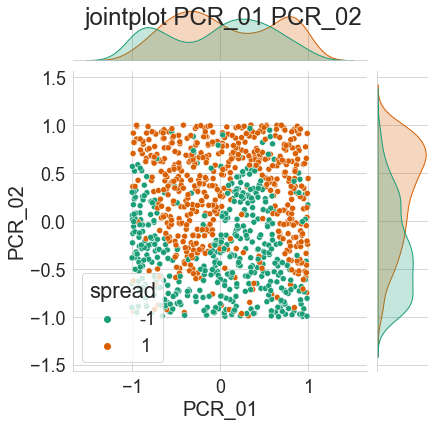

In [4]:
#(Q1)
tmp_df = train_df_prepared[["spread", "PCR_01", "PCR_02"]]
p_PCR01_PCR02 = sns.jointplot(data=tmp_df, x='PCR_01', y='PCR_02', hue='spread', palette = "Dark2")
p_PCR01_PCR02.fig.suptitle("jointplot PCR_01 PCR_02")

In [5]:
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
        Y = (Y + 1) // 2
        labels = set(Y)

    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

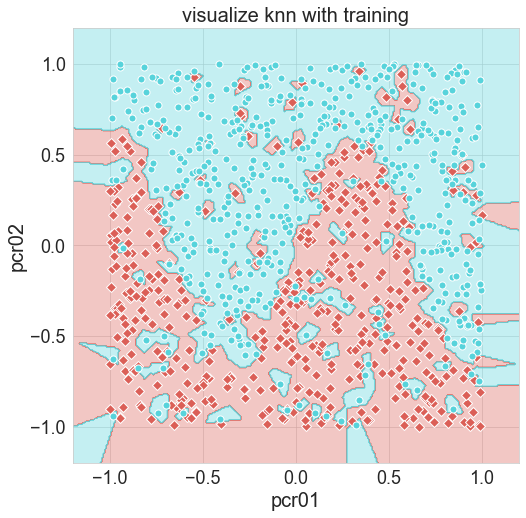

In [6]:
#(Q2)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
df_features = pd.DataFrame(train_df_prepared[['PCR_01', 'PCR_02']]).to_numpy()
df_labels = pd.DataFrame(train_df_prepared[['spread']]).to_numpy()
knn.fit(df_features, np.ravel(df_labels))
visualize_clf(knn, df_features, df_labels, 'visualize knn with training', 'pcr01', 'pcr02')

C:\Users\97254\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\97254\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\97254\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\97254\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

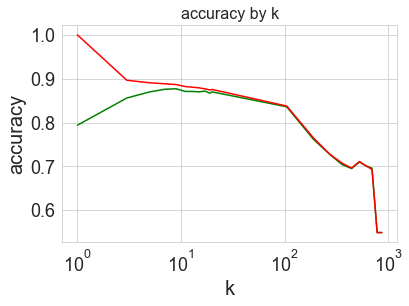

In [7]:
#(Q3)
mean_validations = []
mean_training = []
k_values = list(range(1, 20, 2)) + list(range(20, 871, 85))
df_features = train_df_prepared[["PCR_01","PCR_02"]];
df_labels = train_df_prepared[["spread"]];
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn,df_features ,df_labels, cv=8, return_train_score=True)
    mean_validations.append(np.mean(cv_results['test_score']))
    mean_training.append(np.mean(cv_results['train_score']))
fig = plt.figure(1)
plt.title("accuracy by k", fontsize='16')
plt.xlabel("k")
plt.ylabel("accuracy")
plt.semilogx(k_values, mean_validations, color = "green", label = "validation accuracy")
plt.semilogx(k_values, mean_training, color = "red", label = "train accuracy")

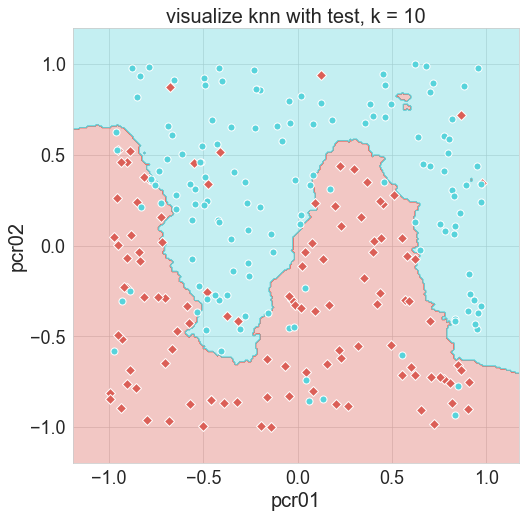

0.864

In [8]:
knn = KNeighborsClassifier(n_neighbors=10)
df_test_features = pd.DataFrame(test_df_prepared[['PCR_01', 'PCR_02']]).to_numpy()
df_test_labels = pd.DataFrame(test_df_prepared[['spread']]).to_numpy()
knn.fit(df_features, np.ravel(df_labels))
visualize_clf(knn, df_test_features, df_test_labels, 'visualize knn with test, k = 10', 'pcr01', 'pcr02')
knn.score(df_test_features, df_test_labels)

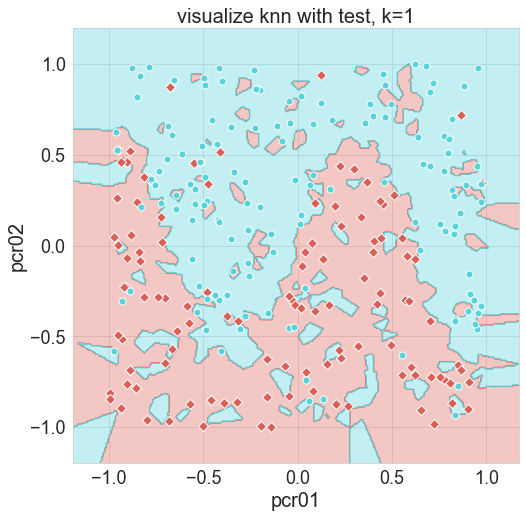

0.808

In [9]:
#(Q5 - k = 1)
knn = KNeighborsClassifier(n_neighbors=1)
df_test_features = pd.DataFrame(test_df_prepared[['PCR_01', 'PCR_02']]).to_numpy()
df_test_labels = pd.DataFrame(test_df_prepared[['spread']]).to_numpy()
knn.fit(df_features, np.ravel(df_labels))
visualize_clf(knn, df_test_features, df_test_labels, 'visualize knn with test, k=1', 'pcr01', 'pcr02')
knn.score(df_test_features, df_test_labels)

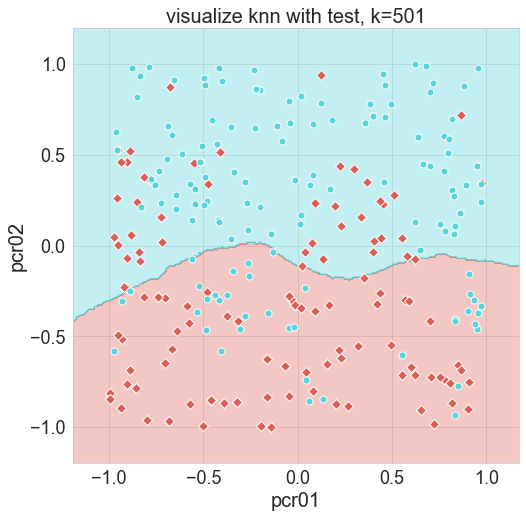

0.668

In [10]:
#(Q5 - k = 501)
knn = KNeighborsClassifier(n_neighbors=501)
df_test_features = pd.DataFrame(test_df_prepared[['PCR_01', 'PCR_02']]).to_numpy()
df_test_labels = pd.DataFrame(test_df_prepared[['spread']]).to_numpy()
knn.fit(df_features, np.ravel(df_labels))
visualize_clf(knn, df_test_features, df_test_labels, 'visualize knn with test, k=501', 'pcr01', 'pcr02')
knn.score(df_test_features, df_test_labels)

C:\Users\97254\AppData\Local\Temp/ipykernel_13636/2479935814.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_features = train_df_prepared.drop(["spread","risk"],1)
C:\Users\97254\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\97254\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\97254\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), fo

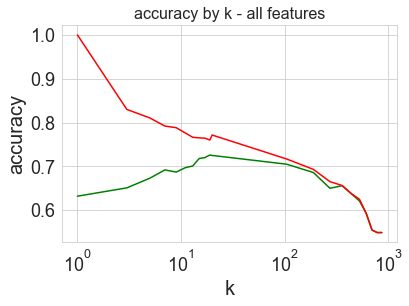

In [11]:
#(Q6)
mean_validations = []
mean_training = []
k_values = list(range(1, 20, 2)) + list(range(20, 871, 85))
df_features = train_df_prepared.drop(["spread","risk"],1)
df_labels = train_df_prepared[["spread"]]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn,df_features ,df_labels, cv=8, return_train_score=True)
    mean_validations.append(np.mean(cv_results['test_score']))
    mean_training.append(np.mean(cv_results['train_score']))
fig = plt.figure(1)
plt.title("accuracy by k - all features", fontsize='16')
plt.xlabel("k")
plt.ylabel("accuracy")
plt.semilogx(k_values, mean_validations, color = "green", label = "validation accuracy")
plt.semilogx(k_values, mean_training, color = "red", label = "train accuracy")

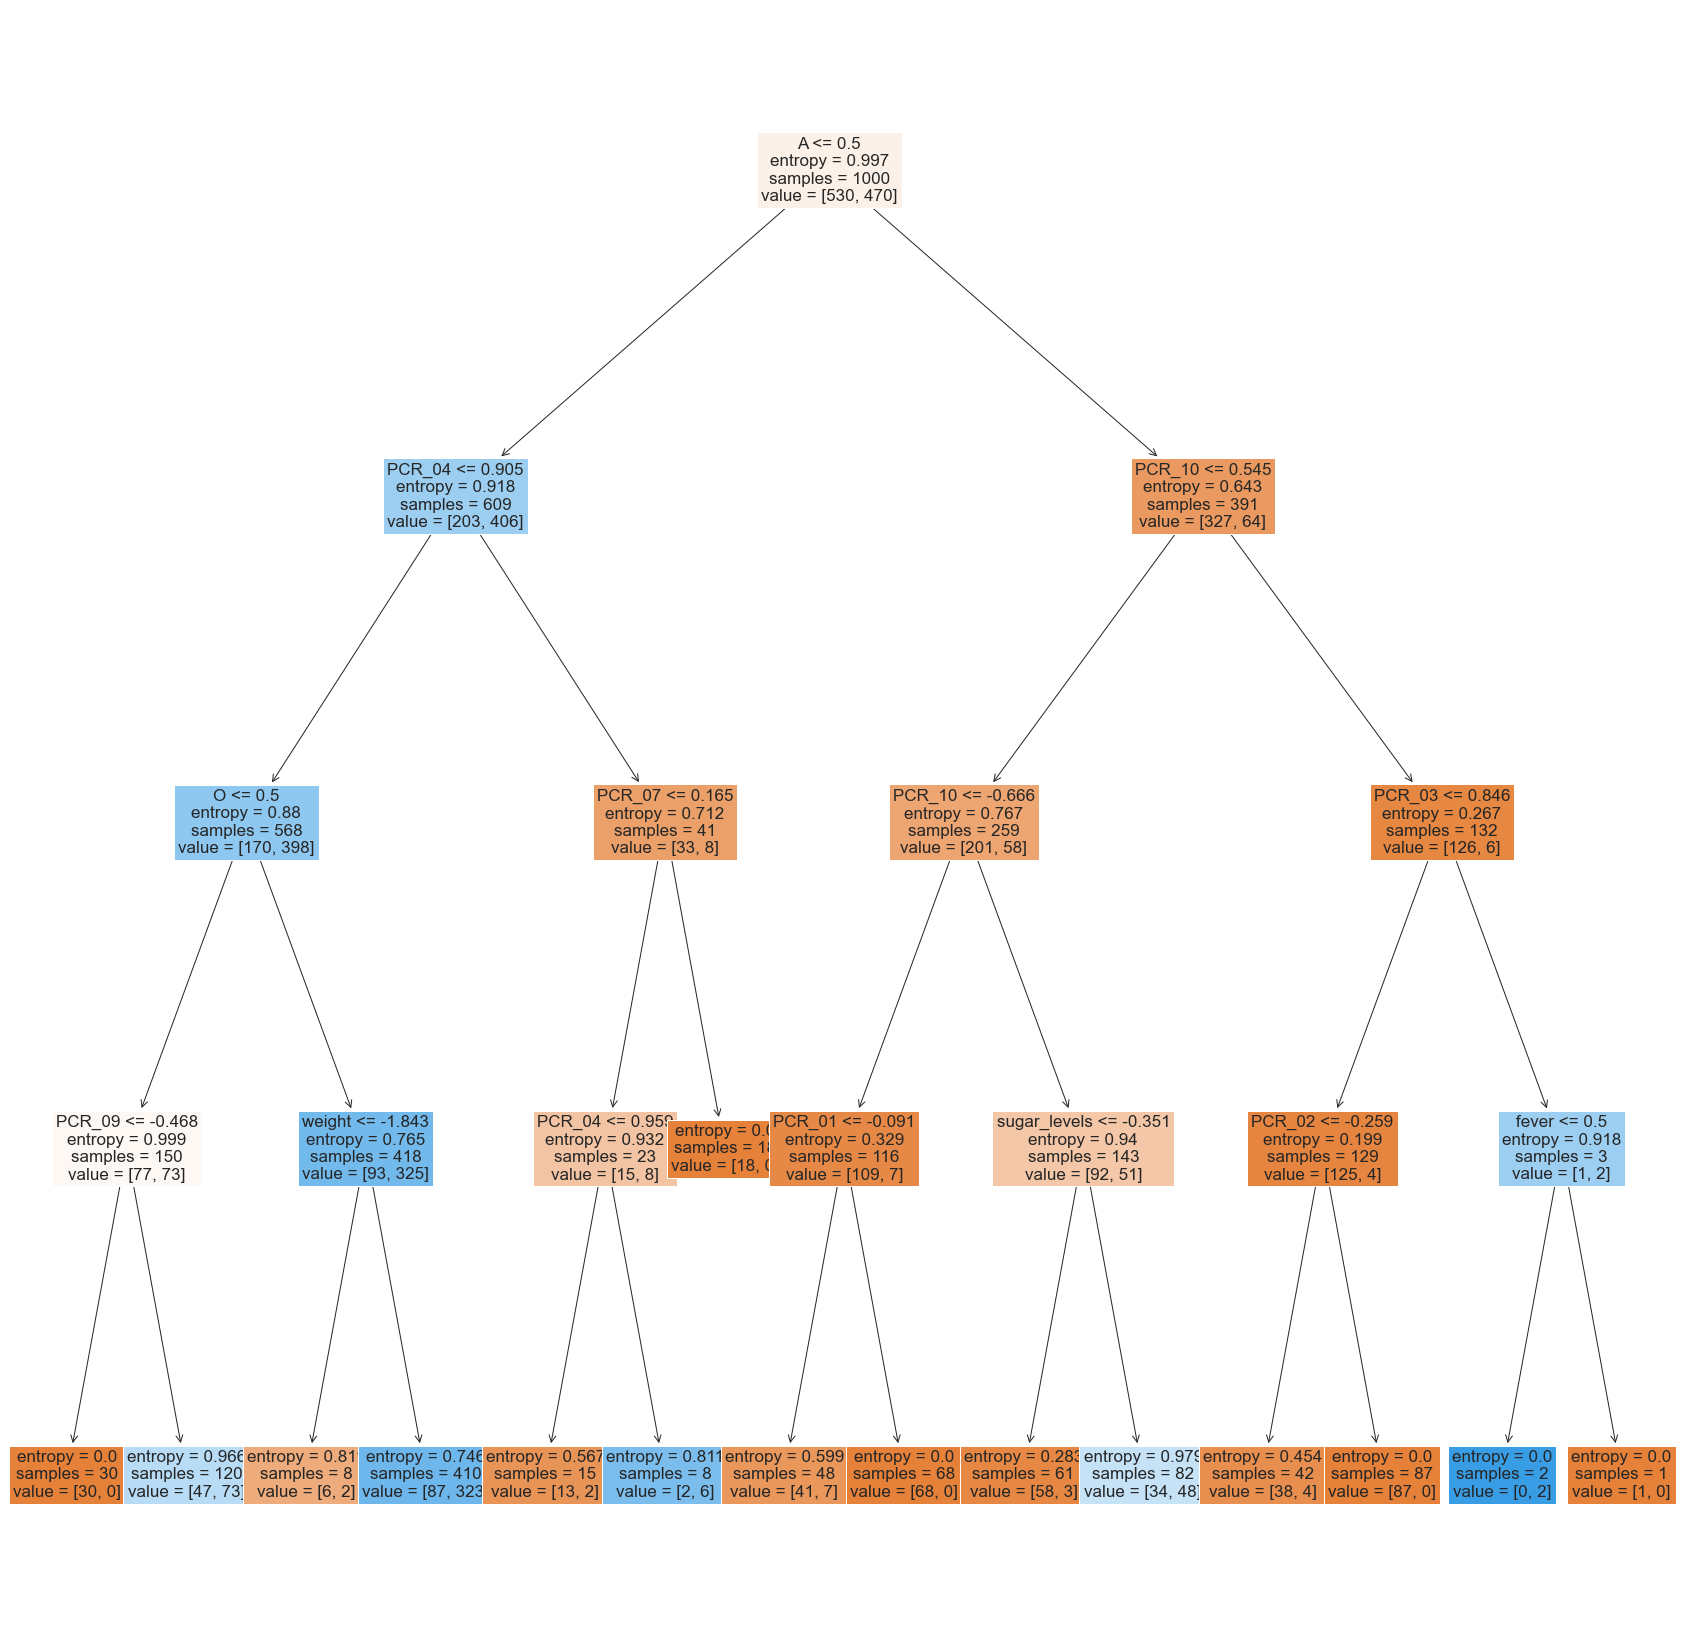

In [12]:
#(Q7)
df_labels = train_df_prepared[["risk"]]
dec_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
dec_tree.fit(df_features, df_labels)
dec_tree.score(df_features, df_labels)
fig = plt.figure(figsize=(30, 30))
_ = plot_tree(dec_tree, filled = True, fontsize=17, feature_names=list(df_features.columns))

In [40]:
#(Q8)
new_dec_tree = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth':range(5,13), 'min_samples_leaf':range(5,13)}
grid_search = GridSearchCV(estimator= new_dec_tree, cv = 8, param_grid=parameters, return_train_score=True)
grid_search.fit(df_features, df_labels)

print("depth: ", grid_search.best_estimator_.get_depth(), " leaf: ", grid_search.best_estimator_.min_samples_leaf, " best score: ", grid_search.best_score_)

depth:  8  leaf:  7  best score:  0.86


In [41]:
train_score = grid_search.cv_results_['mean_train_score']
test_score = grid_search.cv_results_['mean_test_score']
indexes = grid_search.cv_results_['params']
data = pd.DataFrame(columns=['max_depth', 'min_samples_leaf', 'train_score', 'test_score'])
for i, param in enumerate(indexes):
    data.loc[i] = {'max_depth': param['max_depth'], 'min_samples_leaf': param['min_samples_leaf'],
                   'train_score': train_score[i], 'test_score': test_score[i]}

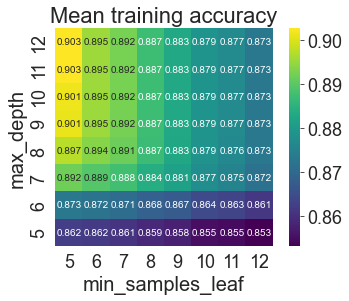

In [42]:
g = sns.heatmap(data.pivot('max_depth', 'min_samples_leaf', 'train_score'), annot = True, xticklabels=True,
                yticklabels=True, square=True, cmap="viridis", fmt='.3f')
g.invert_yaxis()
_ = plt.title('Mean training accuracy')

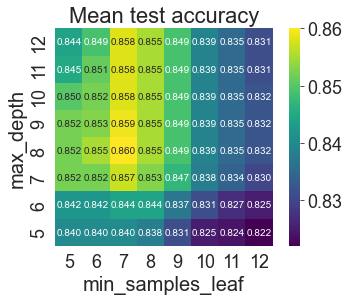

In [43]:
g = sns.heatmap(data.pivot('max_depth', 'min_samples_leaf', 'test_score'), annot = True, xticklabels=True,
                yticklabels=True, square=True, cmap="viridis", fmt='.3f')
g.invert_yaxis()
_ = plt.title('Mean test accuracy')

In [44]:
#(Q9)
dec_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8 ,min_samples_leaf=8)
dec_tree.fit(df_features, df_labels)
dec_tree.score(df_features, df_labels)


0.884

In [18]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b

In [19]:
def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()

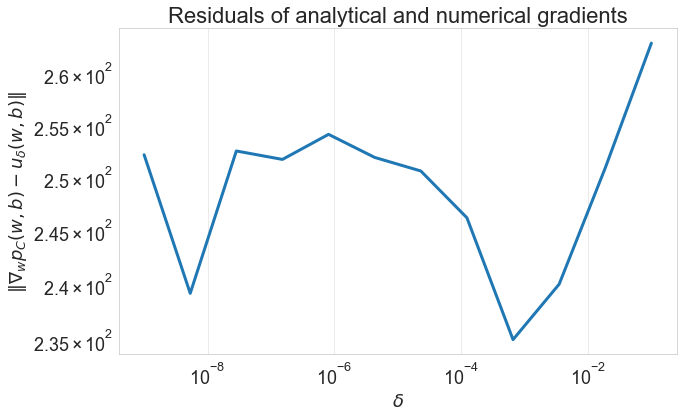

In [20]:
#(Q10)
df_features = train_df_prepared[["PCR_01", "PCR_02"]].to_numpy()
df_labels = train_df_prepared[["spread"]].to_numpy()
compare_gradients(df_features, df_labels, deltas=np.logspace(-9, -1, 12))

In [21]:
a  = np.array([[1] ,[2] ,[3]])
print(a)
a = np.squeeze(a)
print(a)
b = np.array([[1, 2], [3, 4]])
print(b.T)

[[1]
 [2]
 [3]]
[1 2 3]
[[1 3]
 [2 4]]


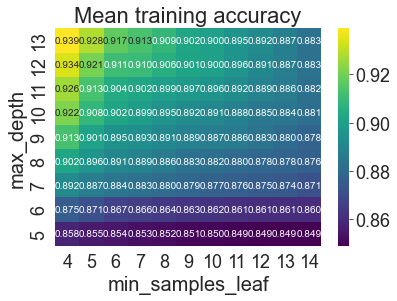

In [22]:
# g = sns.heatmap(data.pivot('max_depth', 'min_samples_leaf', 'train_score'), annot = True, xticklabels=True,
#                 yticklabels=True, square=True, cmap="viridis", fmt='.3f')
# g.invert_yaxis()
# _ = plt.title('Mean training accuracy')

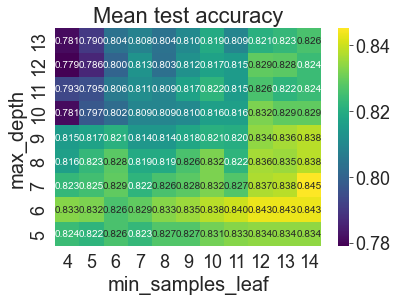

In [23]:
# g = sns.heatmap(data.pivot('max_depth', 'min_samples_leaf', 'test_score'), annot = True, xticklabels=True,
#                 yticklabels=True, square=True, cmap="viridis", fmt='.3f')
# g.invert_yaxis()
# _ = plt.title('Mean test accuracy')

In [45]:
#(Q9)
# dec_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8 ,min_samples_leaf=8)
# dec_tree.fit(df_features, df_labels)
# dec_tree.score(df_features, df_labels)


0.884

In [25]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b

In [26]:
def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()

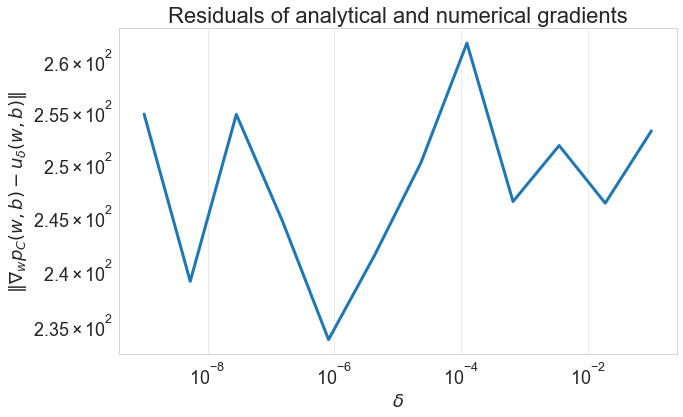

In [27]:
#(Q10)
df_features = train_df_prepared[["PCR_01", "PCR_02"]].to_numpy()
df_labels = train_df_prepared[["spread"]].to_numpy()
compare_gradients(df_features, df_labels, deltas=np.logspace(-9, -1, 12))


learning rate is:  0.001
learning rate is:  0.01
learning rate is:  0.1
learning rate is:  1.0


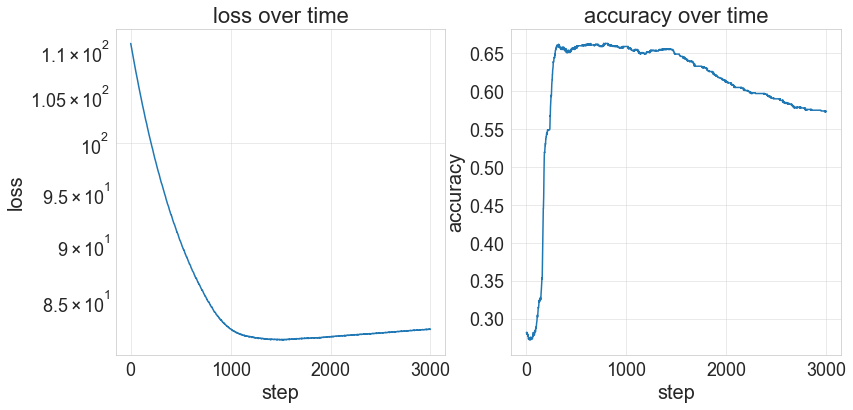

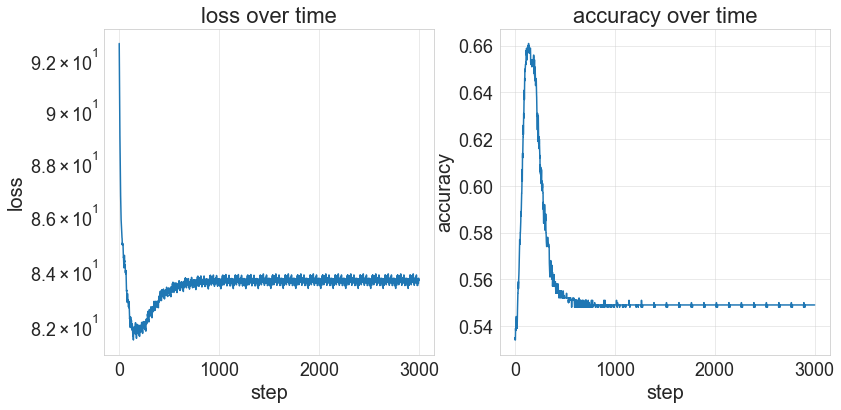

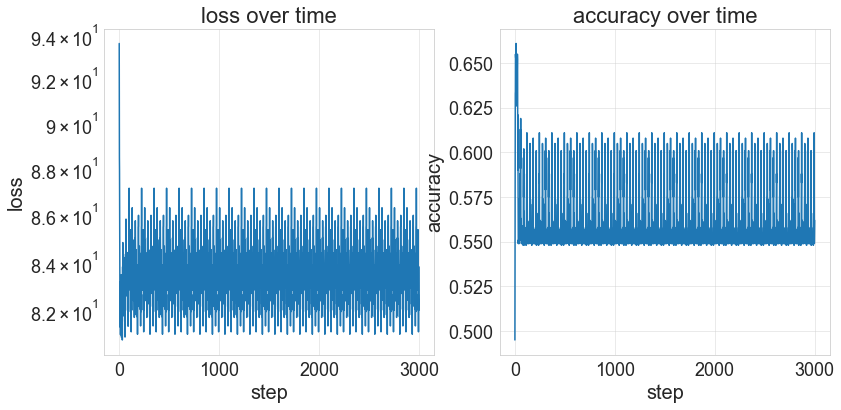

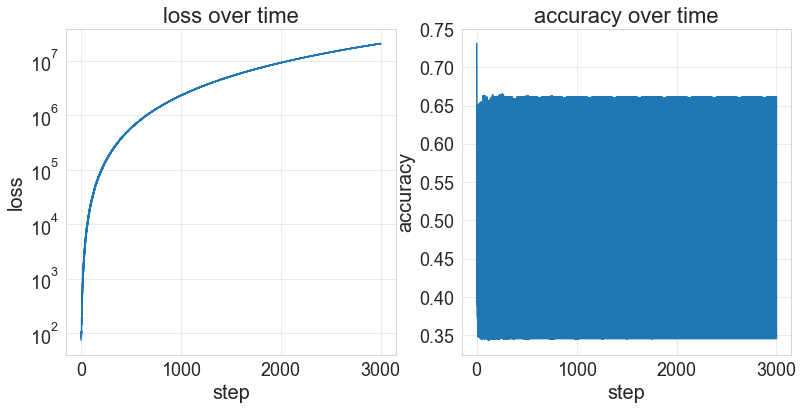

In [58]:
lr_values = np.asarray(np.logspace(-3, 0, 4))
for lr in range(lr_values.size):
    print("learning rate is: ", lr_values[lr])
    clf = SoftSVM(C=0.1, lr=lr_values[lr])
    losses, accuracies = clf.fit_with_logs(df_features, df_labels, max_iter=3000)
    plt.figure(figsize=(13, 6))
    plt.subplot(121), plt.grid(alpha=0.5), plt.title ("loss over time")
    plt.semilogy(losses), plt.xlabel("step"
                                     ""), plt.ylabel("loss")
    plt.subplot(122), plt.grid(alpha=0.5), plt.title ("accuracy over time")
    plt.plot(accuracies), plt.xlabel("step"), plt.ylabel("accuracy")

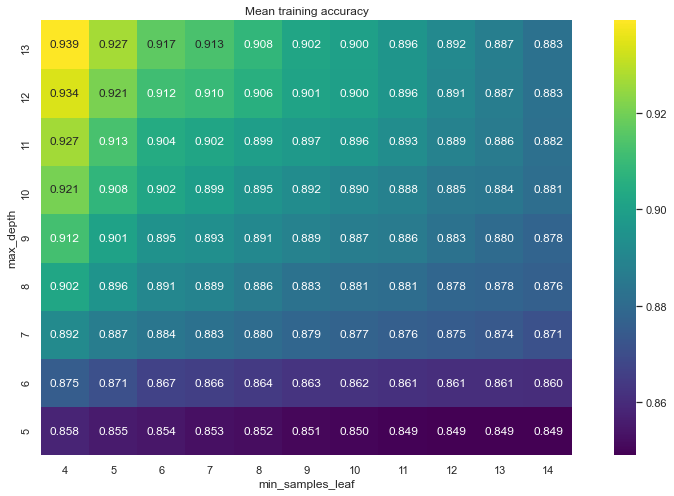

In [121]:
g = sns.heatmap(data.pivot('max_depth', 'min_samples_leaf', 'train_score'), annot = True, xticklabels=True,
                yticklabels=True, square=True, cmap="viridis", fmt='.3f')
g.invert_yaxis()
_ = plt.title('Mean training accuracy')

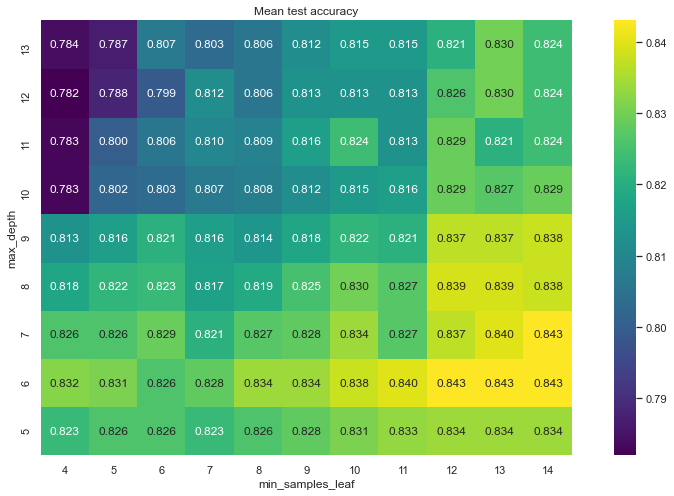

In [122]:
g = sns.heatmap(data.pivot('max_depth', 'min_samples_leaf', 'test_score'), annot = True, xticklabels=True,
                yticklabels=True, square=True, cmap="viridis", fmt='.3f')
g.invert_yaxis()
_ = plt.title('Mean test accuracy')

In [123]:
#(Q9)
dec_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8 ,min_samples_leaf=8)
dec_tree.fit(df_features, df_labels)
dec_tree.score(df_features, df_labels)


0.891

In [124]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b

In [129]:
def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()

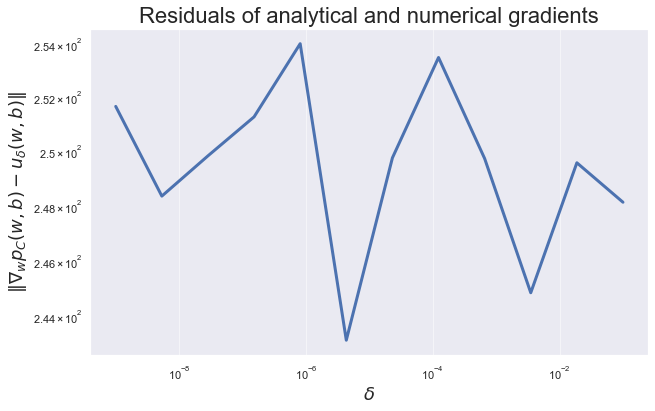

In [147]:
#(Q10)
df_features = train_df_prepared[["PCR_01", "PCR_02"]].to_numpy()
df_labels = train_df_prepared[["spread"]].to_numpy()
compare_gradients(df_features, df_labels, deltas=np.logspace(-9, -1, 12))


In [168]:
lr_values = np.asarray(np.logspace(-3, 0, 4))
for lr in range(lr_values.size):
    clf = SoftSVM(C=0.1, lr=lr_values[lr])
    losses, accuracies = clf.fit_with_logs(df_features, df_labels, max_iter=3000)
    plt.figure(figsize=(13, 6))
    plt.subplot(121), plt.grid(alpha=0.5), plt.title ("TODO")
    plt.semilogy(losses), plt.xlabel("TODO"), plt.ylabel("TODO")
    plt.subplot(122), plt.grid(alpha=0.5), plt.title ("TODO")
    plt.plot(accuracies), plt.xlabel("TODO"), plt.ylabel("TODO")

KeyboardInterrupt: 